In [1]:
import collections
import numpy as np
import random
import time
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import re
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()

In [2]:
class Word2VecModel:
    
    def __init__(self, batch_size, dimension_size, learning_rate, vocabulary_size):
        
        self.train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        self.train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, dimension_size], -1.0, 1.0))
        
        embed = tf.nn.embedding_lookup(embeddings, self.train_inputs)
        
        self.nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, dimension_size], stddev = 1.0 / np.sqrt(dimension_size)))
        
        self.nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        
        self.loss = tf.reduce_mean(tf.nn.nce_loss(weights = self.nce_weights, biases = self.nce_biases, labels = self.train_labels,
                                                  inputs=embed, num_sampled = batch_size / 2, num_classes = vocabulary_size))
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        
        self.norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        
        self.normalized_embeddings = embeddings / self.norm

In [3]:
def clearstring(string):
    string = re.sub('[^A-Za-z0-9 ]+', '', string)
    string = string.split(' ')
    string = filter(None, string)
    string = [y.strip() for y in string]
    string = ' '.join(string)
    return string

def read_data():
    
    list_folder = os.listdir('data')
    label = list_folder; label.sort()
    label_int = LabelEncoder().fit_transform(label)
    outer_string = []; outer_label = []
    for i in xrange(len(list_folder)):
        list_file = os.listdir('data/' + list_folder[i])
        strings = []
        for x in xrange(len(list_file)):
            with open('data/' + list_folder[i] + '/' + list_file[x], 'rb') as fopen:
                strings += fopen.read().split('\n')
        strings = filter(None, strings)
        for x in xrange(len(strings)):
            strings[x] = clearstring(strings[x])
        labels = [label_int[i]] * len(strings)
        outer_string += strings
        outer_label += labels
    
    dataset = np.array([outer_string, outer_label])
    dataset = dataset.T
    np.random.shuffle(dataset)
    
    string = []
    for i in xrange(dataset.shape[0]):
        string += dataset[i][0].split()
    
    vocab = list(set(string))
    return string, dataset, label, vocab

def build_dataset(words, vocabulary_size):
    count = []
    count.extend(collections.Counter(words).most_common(vocabulary_size))

    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)

    data = []
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]

        data.append(index)
    
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, dictionary, reverse_dictionary

def generate_batch_skipgram(words, batch_size, num_skips, skip_window):
    data_index = 0
    
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    
    for i in xrange(span):
        buffer.append(words[data_index])
        data_index = (data_index + 1) % len(words)
    
    for i in xrange(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        
        for j in xrange(num_skips):
            
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        
        buffer.append(words[data_index])
        data_index = (data_index + 1) % len(words)
    
    data_index = (data_index + len(words) - span) % len(words)
    return batch, labels

def generatevector(dimension, batch_size, skip_size, skip_window, num_skips, iteration, words_real):
    
    print "Data size: " + str(len(words_real))

    data, dictionary, reverse_dictionary = build_dataset(words_real, len(words_real))
    
    sess = tf.InteractiveSession()
    print "Creating Word2Vec model.."
    
    model = Word2VecModel(batch_size, dimension, 0.1, len(dictionary))
    sess.run(tf.global_variables_initializer())
    
    last_time = time.time()
    
    for step in xrange(iteration):
        batch_inputs, batch_labels = generate_batch_skipgram(data, batch_size, num_skips, skip_window)
        feed_dict = {model.train_inputs: batch_inputs, model.train_labels: batch_labels}
        
        _, loss = sess.run([model.optimizer, model.loss], feed_dict=feed_dict)
        
        if ((step + 1) % 1000) == 0:
            
            new_time = time.time()
            diff = new_time - last_time
            last_time = new_time
            print "batch: " + str(step + 1) + ", loss: " + str(loss) + ", speed: " + str(diff) + " batches / s"
    
    tf.reset_default_graph()       
    return dictionary, reverse_dictionary, model.normalized_embeddings.eval()

In [9]:
class Model:
    
    def __init__(self, num_layers, size_layer, dimension_input, dimension_output, learning_rate):
        
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(size_layer, activation = tf.nn.relu)
        
        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in xrange(num_layers)])
        
        self.X = tf.placeholder(tf.float32, [None, None, dimension_input])
        self.Y = tf.placeholder(tf.float32, [None, dimension_output])
        
        self.outputs, self.last_state = tf.nn.dynamic_rnn(self.rnn_cells, self.X, dtype = tf.float32)
        
        self.rnn_W = tf.Variable(tf.random_normal((size_layer, dimension_output)))
        self.rnn_B = tf.Variable(tf.random_normal([dimension_output]))
        
        self.logits = tf.matmul(self.outputs[-1], self.rnn_W) + self.rnn_B
        
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.Y))
        
        self.delta = tf.placeholder(tf.float32)
        
        l2 = sum(self.delta * tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
        
        self.cost += l2
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

In [10]:
def train(data_train, data_test, vocab, vectors, dictionary, epoch, model, label, dimension, batch, dimension_input, word2vec = False):
    ACCURACY_TRAIN, ACCURACY_TEST, EPOCH, LOST, last_accuracy_test = [], [], [], [], 0
    delta = 0.0005
    for n in xrange(epoch):
        total_cost = 0; total_accuracy = 0; last_time = time.time(); EPOCH.append(n)
        for i in xrange(0, (data_train.shape[0] // batch) * batch, batch):               
            batch_x = np.zeros((dimension, batch, dimension_input))
            batch_y = np.zeros((batch, len(label)))
            for k in xrange(batch):
                x = np.zeros((dimension, dimension_input), dtype = np.float32)
                
                for _, text in enumerate(data_train[i + k, 0].split()):
                    try:
                        if word2vec:
                            x[:, vocab.index(text)] += vectors[dictionary[text], :]
                        else:
                            x[0, vocab.index(text)] += 1.0
                    except Exception as e:
                        print e
                        continue
                        
                batch_y[k, int(data_train[i + k, 1])] = 1.0
                batch_x[:, k, :] = x[:, :]
            loss, _ = sess.run([model.cost, model.optimizer], feed_dict = {model.X : batch_x, model.Y : batch_y, model.delta: delta})
            total_accuracy += sess.run(model.accuracy, feed_dict = {model.X : batch_x, model.Y : batch_y, model.delta: delta})
            total_cost += loss
            
        diff = time.time() - last_time
        total_accuracy /= (data_train.shape[0] // batch)
        total_cost /= (data_train.shape[0] // batch)
        ACCURACY_TRAIN.append(total_accuracy)
        LOST.append(total_cost)
        print "total accuracy during training: " + str(total_accuracy)
        print "epoch: " + str(n + 1) + ", loss: " + str(total_cost) + ", speed: " + str(diff / ((data.shape[0] - batch) / batch)) + "s / batch"
        
        batch_x = np.zeros((dimension, data_test.shape[0], dimension_input))
        batch_y = np.zeros((data_test.shape[0], len(label)))
        for k in xrange(data_test.shape[0]):
            x = np.zeros((dimension, dimension_input), dtype = np.float32)
            for _, text in enumerate(data_test[k, 0].split()):
                try:
                    if word2vec:
                        x[:, vocab.index(text)] += vectors[dictionary[text], :]
                    else:
                        x[0, vocab.index(text)] += 1.0
                except:
                    continue
                    
            batch_y[k, int(data_test[k, 1])] = 1.0
            batch_x[:, k, :] = x[:, :]
        accuracy_test = sess.run(model.accuracy, feed_dict = {model.X : batch_x, model.Y : batch_y, model.delta: delta})
        if last_accuracy_test > accuracy_test:
            delta += 0.0005
        last_accuracy_test = accuracy_test
        ACCURACY_TEST.append(accuracy_test)
        print "total accuracy during testing: " + str(accuracy_test)
        logits = sess.run(tf.cast(tf.argmax(model.logits, 1), tf.int32), feed_dict = {model.X : batch_x})
        print(metrics.classification_report(data_test[:, 1].astype(int), logits, target_names = label))
    
    fig = plt.figure(figsize = (15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(EPOCH, LOST)
    plt.xlabel('Epoch')
    plt.ylabel('lost')
    plt.title('LOST')
    plt.subplot(1, 2, 2)
    plt.plot(EPOCH, ACCURACY_TRAIN, label = 'accuracy train')
    plt.plot(EPOCH, ACCURACY_TEST, label = 'accuracy testing')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('ACCURACY')
    
    fig.tight_layout()
    plt.show()

In [6]:
dimension = 32
skip_size = 8
skip_window = 1
num_skips = 2
iteration_train_vectors = 10000

num_layers = 2
size_layer = 256
learning_rate = 0.0001
epoch = 20
batch = 32
string, data, label, vocab = read_data()
dictionary, reverse_dictionary, vectors = generatevector(dimension, dimension, skip_size, skip_window, num_skips, iteration_train_vectors, string)
dimension_input = len(vocab)

Data size: 197234
Creating Word2Vec model..
batch: 1000, loss: 32.7985, speed: 2.56978297234 batches / s
batch: 2000, loss: 21.5206, speed: 2.41702795029 batches / s
batch: 3000, loss: 19.1797, speed: 2.42128515244 batches / s
batch: 4000, loss: 15.0476, speed: 2.42679095268 batches / s
batch: 5000, loss: 19.365, speed: 2.43071389198 batches / s
batch: 6000, loss: 0.99891, speed: 2.43292117119 batches / s
batch: 7000, loss: 19.7497, speed: 2.41831684113 batches / s
batch: 8000, loss: 0.885831, speed: 2.41968894005 batches / s
batch: 9000, loss: 26.0175, speed: 2.42494010925 batches / s
batch: 10000, loss: 0.720873, speed: 2.42597603798 batches / s


In [7]:
train_dataset = data[:int(data.shape[0] * 0.80), :]
test_dataset = data[int(data.shape[0] * 0.80):, :]

total accuracy during training: 0.532777255639
epoch: 1, loss: 1.0432786332, speed: 0.267181099179s / batch
total accuracy during testing: 0.504923
             precision    recall  f1-score   support

   negative       0.50      0.98      0.67      1075
   positive       0.52      0.02      0.04      1058

avg / total       0.51      0.50      0.36      2133

total accuracy during training: 0.648731203008
epoch: 2, loss: 0.836440230447, speed: 0.267056620265s / batch
total accuracy during testing: 0.535865
             precision    recall  f1-score   support

   negative       0.53      0.77      0.62      1075
   positive       0.56      0.30      0.39      1058

avg / total       0.54      0.54      0.51      2133

total accuracy during training: 0.686207706767
epoch: 3, loss: 0.765904687849, speed: 0.265972454864s / batch
total accuracy during testing: 0.558837
             precision    recall  f1-score   support

   negative       0.54      0.87      0.67      1075
   positive    

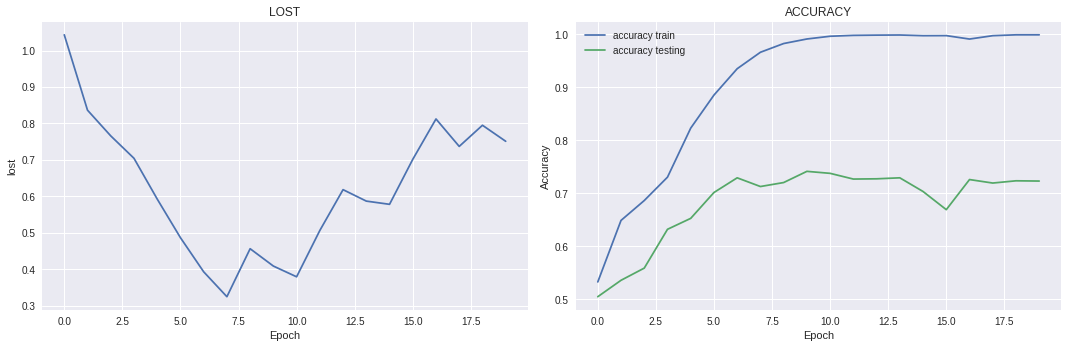

In [11]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(num_layers, size_layer, dimension_input, len(label), learning_rate)
sess.run(tf.global_variables_initializer())
train(train_dataset, test_dataset, vocab, vectors, dictionary, epoch, model, label, 1, 
      batch, dimension_input, word2vec = False)